# Calculating SNR and CNR with Gaussian Mixture Models
## Phantom Validation

The signal-to-noise ratio (SNR) and contrast-to-noise ratio (CNR) of a 3D stack of greyscale images can be determined from the histogram of the grey values in the stack. Each material in the image (e.g. air, wax, tissue) is represented by a Gaussian distribution of grey values with a mean $\mu$, standard deviation $\sigma$ and weight <i><b>w</i></b>. SNR and CNR then calculated by the following equations:

\begin{equation*}
SNR = \frac{\mu_A}{\sigma_B}
\end{equation*}

\begin{equation*}
CNR = \frac{|\mu_A - \mu_B|}{\sqrt{\sigma_A^2+\sigma_B^2}}
\end{equation*}

A phantom was created to validate this SNR and CNR measure. An example 3D micro-CT image stack kindly provided by Harry Rossides was segmented to produce three masks, each corresponding to air, wax and tissue respectively. Each pixel within each mask was assigned a random grey value from a normal distribution with a known $\mu$ and $\sigma$. Several tests are then performed with this phantom with known Gaussian distributions of each material.

In [1]:
%run "Phantom_Validation_Hidden.py" # Imports functions and libraries to calculate Q

# Phantom Generation

The first slice of each mask can be viewed in the cell below.

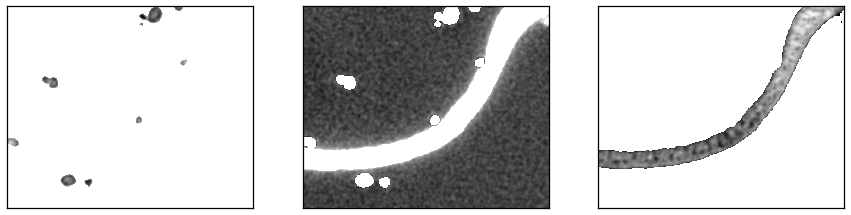

In [2]:
image_names = ['Air','Wax','Tissue']
fig = plt.figure(figsize = [15.,5.])
plt.style.use('grayscale')

for i in range(0,len(image_names)):
    plt.subplot(1,3,i+1)
#     plt.title(image_names[i]+' [{}]'.format(str(i)),fontsize=40)
    plt.imshow(io.imread(os.path.join(test_dir, "{}.tif".format(image_names[i])))[0]) # first slice only
    plt.xticks([])
    plt.yticks([])

plt.savefig("poster.png", dpi = 100)


## Assigning new grey values

The grey values of the pixels in each mask were replaced with random values from Gaussian distributions of known $\mu$ and $\sigma$. 

Phantom means are [8, 35, 82]
Phantom standard deviations are [7, 6, 16]
Phantom successfully created


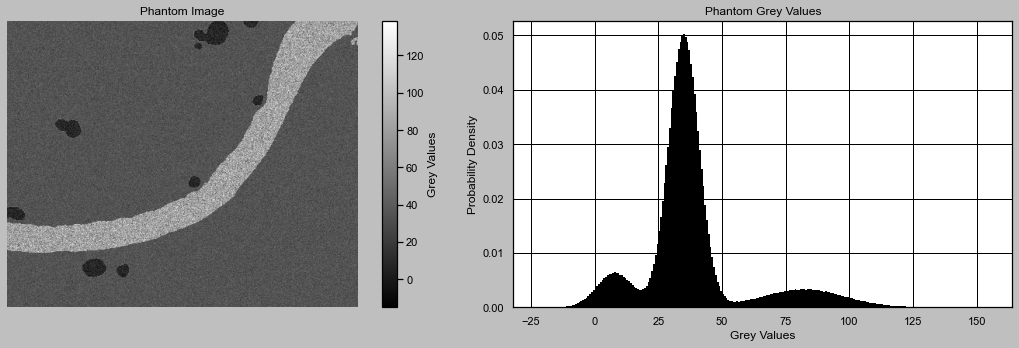

In [3]:
mu_phantom = [8, 35, 82] # phantom mu for air, wax, tissue
sigma_phantom = [7, 6, 16] # phantom sigma for air, wax, tissue

I_phantom = create_phantom.create_phantom(mu_phantom, sigma_phantom, test_dir)
create_phantom.show_phantom(I_phantom)

# Fitting Gaussian distributions

SNR and CNR were calculated by fitting three Gaussian distributions to the phantom image stack histogram (one for each material). Firstly, the accuracy of the fitted Gaussian distributions was assessed by comparing the properties of the fitted and phantom distributions.

Percentage error was calculated with the following equations:

\begin{equation*}
\% \;error \;in \; \mu= 100 \cdot \frac{\mu_{phantom} - \mu}{\mu_{phantom}}
\end{equation*}

\begin{equation*}
\% \;error \;in \; \sigma = 100 \cdot \frac{\sigma_{phantom} - \sigma}{\sigma_{phantom}}
\end{equation*}

GMM fit complete, time elapsed = 8.25 s 
 



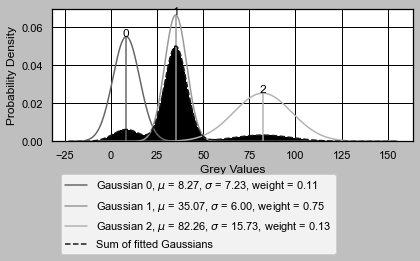

,Air,Wax,Tissue
% difference $\mu$,-3.357317,-0.200043,-0.314480
% difference $\sigma$,-3.334877,0.036104,1.712036


In [4]:
mu_fitted, sigma_fitted = QM_fit.QM_fit(I_phantom, 3, img_fname = "NA", save_results = False) # fit Gaussian distributions

pct_diff_mu = map(calc_pct_diff, mu_phantom, mu_fitted) # calculate % diff in mu
pct_diff_sigma = map(calc_pct_diff, sigma_phantom, sigma_fitted) # calculate % diff in sigma

# Display results
df = pd.DataFrame([pct_diff_mu, pct_diff_sigma], 
                  index = ["% difference $\mu$","% difference $\sigma$"], 
                  columns = ["Air", "Wax", "Tissue"]) # convert to pandas df for pretty displays
df_style = df.style.set_caption("Percentage Difference between Fitted and Phantom Distributions")
display(df_style)


# Calculating image quality

The Gaussian distributions were used to calculate SNR and CNR between Gaussians A and B, where A and B were all the different combinations of fitted Gaussians. Here we have three materials represented in the image, so 3 Gaussians were fitted and SNR was calculated between all of them.

$$ SNR = \frac{\mu_{A}}{\sigma_{B}}  $$

$$ CNR = \frac{\mu_{A} - \mu_{B}}{\sqrt{\sigma_{A}^2 + \sigma_{B}^2}} $$

In this case, Gaussian 0 was air, Gaussian 1 was wax and Gaussian 2 was tissue.

The percentage difference in SNR and CNR calculated from the fitted and phantom values was calculated as follows:

\begin{equation*}
\% \text{diff in SNR} = 100 \cdot \frac {|SNR_{fitted} - SNR_{phantom}|}{SNR_{phantom}}
\end{equation*}

\begin{equation*}
\% \text{diff in CNR} = 100 \cdot \frac {|CNR_{fitted} - CNR_{phantom}|}{CNR_{phantom}}
\end{equation*}

In [6]:
# Calculate SNR and CNR for fitted and phantom distributions
SNR_CNR_fitted = QM_calc.QM_calc(mu_fitted, sigma_fitted, results_dir = "NA", save_results = False, verbose = False)
SNR_CNR_phantom = QM_calc.QM_calc(mu_phantom, sigma_phantom, results_dir = "NA", save_results = False, verbose = False)

# Calculate percentage differences in SNR between fitted and phantom distributions
SNR_phantom = np.array(SNR_CNR_phantom.SNR)
SNR_fitted = np.array(SNR_CNR_fitted.SNR)
SNR_pct_diff = (100*np.abs(SNR_phantom - SNR_fitted))/SNR_phantom
print("Average percentage difference in SNR is {:.2f} %".format(np.mean(SNR_pct_diff)))

# Calculate percentage differences in CNR between fitted and phantom distributions
CNR_phantom = np.array(SNR_CNR_phantom.CNR)
CNR_fitted = np.array(SNR_CNR_fitted.CNR)
CNR_pct_diff = (100*np.abs(CNR_phantom - CNR_fitted))/CNR_phantom
print("Average percentage difference in CNR is {:.2f} %".format(np.mean(CNR_pct_diff)))


SNR and CNR Results 
Non-verbose mode
SNR and CNR Results 
Non-verbose mode
Average percentage difference in SNR is 2.80 %
Average percentage difference in CNR is 1.81 %


# Manipulating phantom distributions

The grey value distributions of the phantom image affect the accuracy of the fitted Gaussian distributions and the image quality. Below is an interactive model where the means and standard deviations of the three distributions in the phantoms can be set. Run the following cell and adjust the values of $\mu$ and $\sigma$.


In [7]:
mu_0 = widgets.IntSlider(description = '$\mu_0$', min = 0, max = 255)
mu_1 = widgets.IntSlider(description = '$\mu_1$', min = 0, max = 255)
mu_2 = widgets.IntSlider(description = '$\mu_2$', min = 0, max = 255)

sigma_0 = widgets.IntSlider(description = '$\sigma_0$', min = 5, max = 50)
sigma_1 = widgets.IntSlider(description = '$\sigma_1$', min = 5, max = 50)
sigma_2 = widgets.IntSlider(description = '$\sigma_2$', min = 5, max = 50)

mu_box = widgets.VBox([mu_0, mu_1, mu_2])
sigma_box = widgets.VBox([sigma_0, sigma_1, sigma_2])  
widgets.HBox([mu_box, sigma_box])

## Determining fit accuracy and image quality

Run the following cell to calculate the fit accuracy and image quality based on the grey value distributions chosen before.

\begin{equation*}
\% \;error \;in \; \mu= 100 \cdot \frac{\mu_{interact} - \mu}{\mu_{interact}}
\end{equation*}

\begin{equation*}
\% \;error \;in \; \sigma = 100 \cdot \frac{\sigma_{interact} - \sigma}{\sigma_{interact}}
\end{equation*}

Phantom means are [71, 147, 180]
Phantom standard deviations are [12, 17, 25]
Phantom successfully created


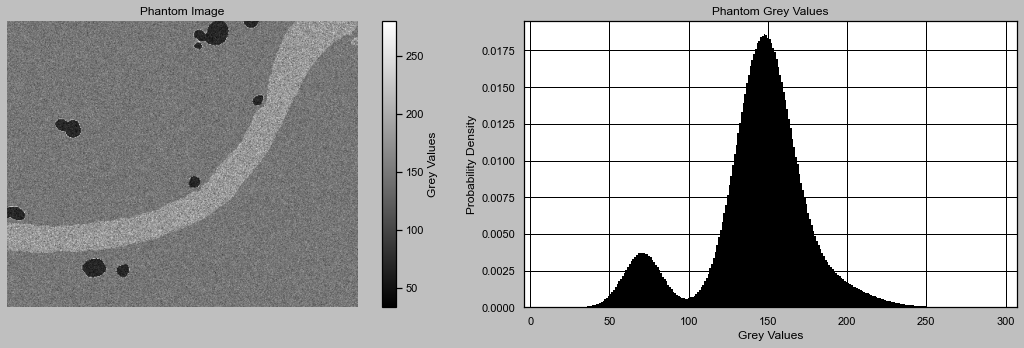

GMM fit complete, time elapsed = 14.92 s 
 



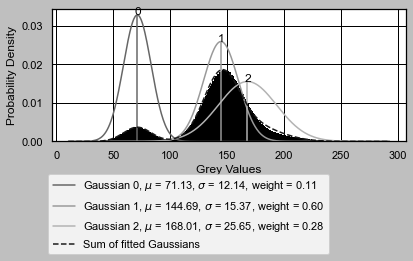

SNR and CNR Results 
SNR = 4.63 and CNR = 3.76 with Gaussian A = 0 and Gaussian B = 1
SNR = 2.77 and CNR = 3.41 with Gaussian A = 0 and Gaussian B = 2
SNR = 11.92 and CNR = 3.76 with Gaussian A = 1 and Gaussian B = 0
SNR = 5.64 and CNR = 0.78 with Gaussian A = 1 and Gaussian B = 2
SNR = 13.84 and CNR = 3.41 with Gaussian A = 2 and Gaussian B = 0
SNR = 10.93 and CNR = 0.78 with Gaussian A = 2 and Gaussian B = 1


,Air,Wax,Tissue
% difference $\mu$,-0.180195,1.569571,6.660853
% difference $\sigma$,-1.191703,9.588383,-2.581205


In [9]:
mu_interact = [mu_0.value, mu_1.value, mu_2.value] # widget outputs
sigma_interact = [sigma_0.value, sigma_1.value, sigma_2.value] # widget outputs

# Create phantom
I_phantom = create_phantom.create_phantom(mu_interact, sigma_interact, test_dir)
create_phantom.show_phantom(I_phantom)

# Fit GMM, calculate and display results
mu_fitted, sigma_fitted = QM_fit.QM_fit(I_phantom, 3, img_fname = "NA", save_results = False) # fit Gaussian distributions
pct_diff_mu = map(calc_pct_diff, mu_interact, mu_fitted) # calculate % diff in mu
pct_diff_sigma = map(calc_pct_diff, sigma_interact, sigma_fitted) # calculate % diff in sigma

SNR_CNR_df = QM_calc.QM_calc(mu_fitted, sigma_fitted, results_dir = "NA", save_results = False) # calc SNR and CNR

# Display results
df = pd.DataFrame([pct_diff_mu, pct_diff_sigma], 
                  index = ["% difference $\mu$","% difference $\sigma$"], 
                  columns = ["Air", "Wax", "Tissue"]) # convert to pandas df for pretty displays
df_style = df.style.set_caption("Percentage Difference between Fitted and Phantom Distributions")
display(df_style)

## Effect of contrast on fit accuracy and image quality

The contrast between tissue and wax is the difference between means of the grey value distributions for tissue and wax. This can be altered by changing the mean of the grey value distribution for tissue. The following cell calculates the percentage difference in fitted and assigned $\mu$ and $\sigma$ for a range of $\mu_{tissue}$ between 40 and 100. The grey value distributions of air and wax were kept constant at the following values:

$\mu_{air}$ = 8, $\sigma_{air}$ = 7

$\mu_{wax}$ = 35, $\sigma_{wax}$ = 6

$\mu_{tissue}$ = variable, $\sigma_{tissue}$ = 17


Creating phantom with mu of tissue = 60.0
Phantom means are [8, 35, 60.0]
Phantom standard deviations are [7, 6, 16]
Phantom successfully created
GMM fit complete, time elapsed = 8.50 s 
 


Creating phantom with mu of tissue = 70.0
Phantom means are [8, 35, 70.0]
Phantom standard deviations are [7, 6, 16]
Phantom successfully created
GMM fit complete, time elapsed = 8.38 s 
 


Creating phantom with mu of tissue = 80.0
Phantom means are [8, 35, 80.0]
Phantom standard deviations are [7, 6, 16]
Phantom successfully created
GMM fit complete, time elapsed = 8.91 s 
 


Creating phantom with mu of tissue = 90.0
Phantom means are [8, 35, 90.0]
Phantom standard deviations are [7, 6, 16]
Phantom successfully created
GMM fit complete, time elapsed = 7.18 s 
 


Creating phantom with mu of tissue = 100.0
Phantom means are [8, 35, 100.0]
Phantom standard deviations are [7, 6, 16]
Phantom successfully created
GMM fit complete, time elapsed = 7.03 s 
 



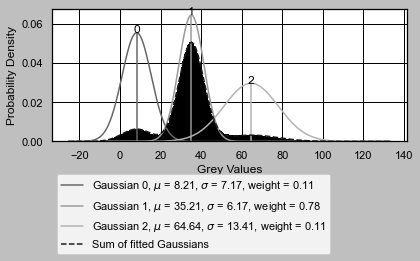

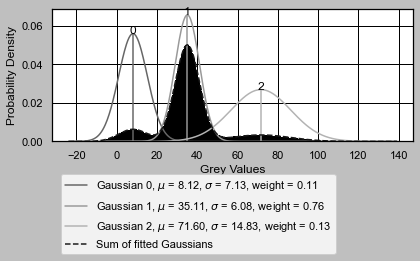

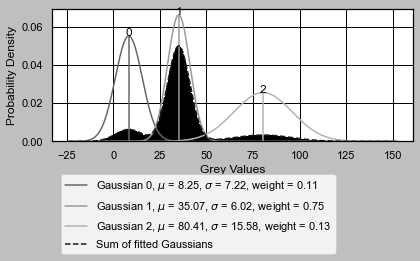

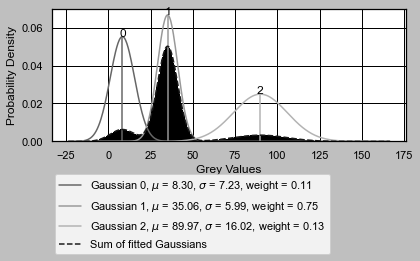

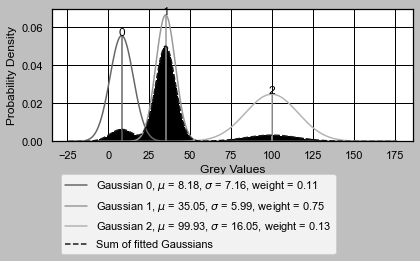

In [10]:
# Define grey value distributions
mu_tissue_contrast = np.linspace(60, 100, 5) # 5 values of mu for tissue between 40 and 100
sigma_phantom = [7, 6, 16] # phantom sigma for air, tissue, wax
pct_diff_mu_results = []
pct_diff_sigma_results = []
CNR = []

for mu in mu_tissue_contrast:
    # Create phantom
    print("\nCreating phantom with mu of tissue =", mu)
    mu_phantom = [8, 35, mu]
    I_phantom = create_phantom.create_phantom(mu_phantom, sigma_phantom, test_dir)
    
    # Fit GMM, calculate results
    mu_fitted, sigma_fitted = QM_fit.QM_fit(I_phantom, 3, img_fname = "NA", save_results = False, show_plots = False)
    pct_diff_mu = list(map(calc_pct_diff, mu_phantom, mu_fitted)) # calculate % diff in mu
    pct_diff_sigma = list(map(calc_pct_diff, sigma_phantom, sigma_fitted)) # calculate % diff in sigma
    pct_diff_mu_results.append(pct_diff_mu)
    pct_diff_sigma_results.append(pct_diff_sigma)
    CNR.append((mu - 35)/np.sqrt(6**2 + 16**2))
    

The following cell plots the percentage differences in fitted and assigned $\mu$ and $\sigma$ for different values of $\mu_{tissue}$. 

<b><u>Accuracy of fitted grey value distributions was found to increase as contrast increases (separation between tissue and wax distributions). The relationship between image quality Q and contrast was approximately linear, where Q and contrast were both determined between wax and tissue grey value distributions.</b></u>

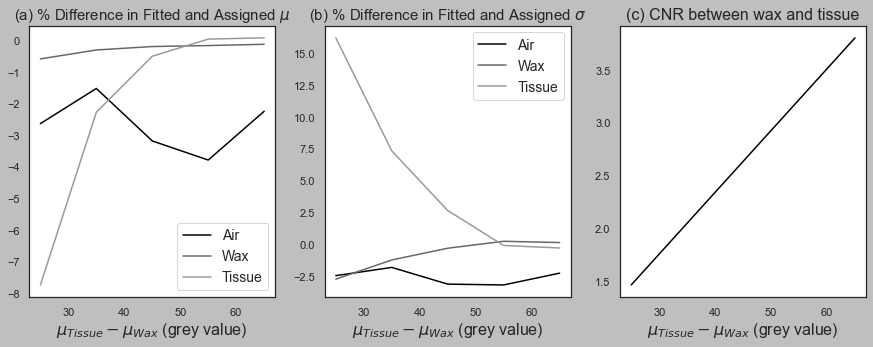

In [11]:
contrast = mu_tissue_contrast - 35 # subtract mu_wax to give contrast between mu_tissue and mu_wax
summary_plot(contrast, "$\mu_{Tissue} - \mu_{Wax}$ (grey value)", pct_diff_mu_results, pct_diff_sigma_results, CNR)

## Effect of distribution spread on fit accuracy and image quality

Distributions with large spreads (standard deviations) close to each other are more likely to overlap. Large areas of overlap between distributions reduce the accuracy of Gaussian distribution fitting and reduce image quality. The standard deviation of the grey value distributions were scaled by a factor of 0.1 to 2 and the means were kept constant. The assigned distributions are shown below:

$\sigma$ scaling factor is a value between 0.1 and 2.

$\mu_{air}$ = 8, $\sigma_{air}$ = 7 x $\sigma$ scaling factor

$\mu_{wax}$ = 35, $\sigma_{wax}$ = 6 x $\sigma$ scaling factor

$\mu_{tissue}$ = 82, $\sigma_{tissue}$ = 17 x $\sigma$ scaling factor



Creating phantom with sigma factor = 0.1
Phantom means are [8, 35, 82]
Phantom standard deviations are [0.7000000000000001, 0.6000000000000001, 1.6]
Phantom successfully created
GMM fit complete, time elapsed = 6.55 s 
 


Creating phantom with sigma factor = 0.575
Phantom means are [8, 35, 82]
Phantom standard deviations are [4.0249999999999995, 3.4499999999999997, 9.2]
Phantom successfully created
GMM fit complete, time elapsed = 5.78 s 
 


Creating phantom with sigma factor = 1.05
Phantom means are [8, 35, 82]
Phantom standard deviations are [7.3500000000000005, 6.300000000000001, 16.8]
Phantom successfully created
GMM fit complete, time elapsed = 7.22 s 
 


Creating phantom with sigma factor = 1.525
Phantom means are [8, 35, 82]
Phantom standard deviations are [10.674999999999999, 9.149999999999999, 24.4]
Phantom successfully created
GMM fit complete, time elapsed = 12.49 s 
 


Creating phantom with sigma factor = 2.0
Phantom means are [8, 35, 82]
Phantom standard deviations ar

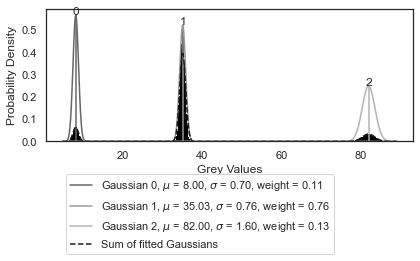

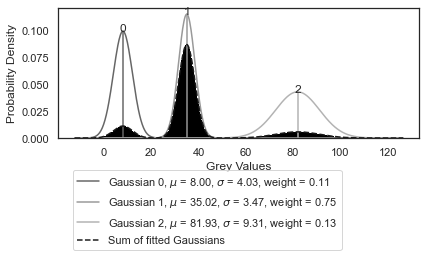

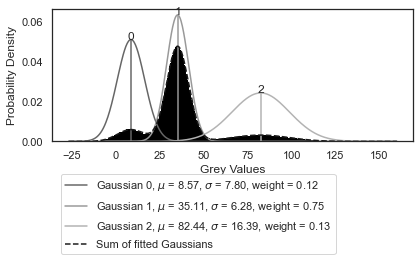

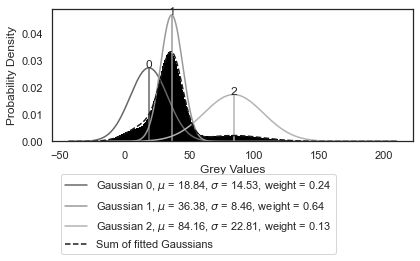

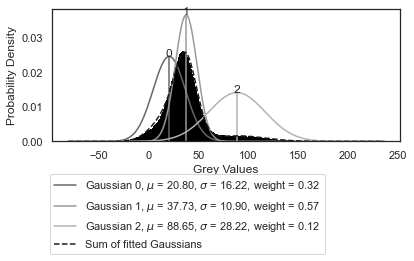

In [12]:
# Define grey value distributions
sigma_factor = np.linspace(0.1, 2, 5) # 5 values of sigma factor
mu_phantom = [8, 35, 82] # phantom mu for air, tissue, wax
sigma_phantom = [7, 6, 16] # phantom sigma for air, tissue, wax
pct_diff_mu_results = []
pct_diff_sigma_results = []
CNR = []

for factor in sigma_factor:
    # Create phantom
    print("\nCreating phantom with sigma factor =", factor)
    sigma_rescaled = [sigma * factor for sigma in sigma_phantom]
    I_phantom = create_phantom.create_phantom(mu_phantom, sigma_rescaled, test_dir)
    
    # Fit GMM, calculate results
    mu_fitted, sigma_fitted = QM_fit.QM_fit(I_phantom, 3, img_fname = "NA", save_results = False, show_plots = False)
    pct_diff_mu = list(map(calc_pct_diff, mu_phantom, mu_fitted)) # calculate % diff in mu
    pct_diff_sigma = list(map(calc_pct_diff, sigma_rescaled, sigma_fitted)) # calculate % diff in sigma
    pct_diff_mu_results.append(pct_diff_mu)
    pct_diff_sigma_results.append(pct_diff_sigma)
    CNR.append((mu_phantom[2] - mu_phantom[1]) / np.sqrt(sigma_rescaled[1]**2 + sigma_rescaled[2]**2))

The following cell plots the percentage differences in fitted and assigned $\mu$ and $\sigma$ for different values of $\sigma$ scaling factor.

<b><u>Accuracy of fitted grey value distributions was found to decrease as standard deviations of grey value distributions for each material increased.

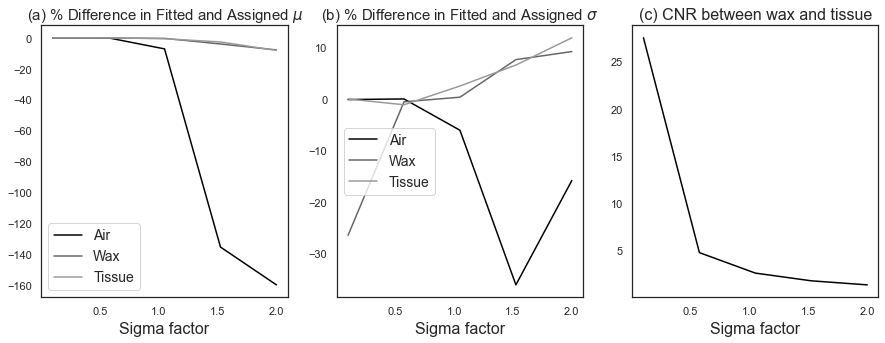

In [13]:
summary_plot(sigma_factor, "Sigma factor", pct_diff_mu_results, pct_diff_sigma_results, CNR)